# Анализ обучения с различными KL-дивергенциями и коэффициентами β

## Введение

В ходе эксперимента была проведена серия обучений с использованием различных видов KL-дивергенции и значений β в кастомном DPOTrainer. Основной целью было исследование влияния этих гиперпараметров на итоговое качество модели, выраженное через Win Rate и величину KL-дивергенции.

## Методология

### 1. Различные KL-дивергенции

Были протестированы три вида KL-дивергенции:

Forward KL – наказывает отклонение модели от референсного распределения.

Alpha-дивергенция (α=0.5) – промежуточный вариант между forward и reverse KL.

JS-дивергенция – усреднённая мера расхождения между двумя распределениями.

### 2. Различные значения β

Для каждого типа KL-дивергенции также варьировался коэффициент β, который регулирует силу регуляризации. Рассматривались следующие значения:

0.05 – очень слабая регуляризация.

0.1 – слабая регуляризация.

1.0 – сбалансированный вариант.

5.0 – сильная регуляризация.

### 3. Процесс обучения

Каждая модель проходила 200 шагов обучения.

Результаты оценивались при помощи llm_blender (PairRM).

## Результаты

### 1. Влияние разных видов KL-дивергенции

Анализ показал, что Win Rate практически не зависит от вида KL-дивергенции и остаётся около 0.23 во всех случаях. Это указывает на слабое влияние выбора KL на финальную производительность модели.

### 2. Влияние β

Результаты для различных значений β:

β = 0.05: Win Rate = 0.22, KL = 0.0531

β = 0.1: Win Rate = 0.23, KL = 0.0349

β = 1.0: Win Rate = 0.09, KL = 0.0150

β = 5.0: Win Rate = 0.12, KL = 0.0140

### Выводы:

При низких значениях β (0.05–0.1) модель сохраняет более высокие значения KL-дивергенции, но показывает относительно стабильный Win Rate.

При умеренных и высоких значениях β (1.0–5.0) KL значительно снижается, но Win Rate падает, что может свидетельствовать о чрезмерной регуляризации модели.

В целом, существует баланс между регулированием расхождения распределений и сохранением качества модели.

## Выводы

Выбор вида KL-дивергенции не оказал заметного влияния на Win Rate.

Изменение β показало, что сильная регуляризация уменьшает KL, но не всегда улучшает производительность модели.

In [ ]:
# !pip install trl
# !pip install datasets
# !pip install llm_blender

In [2]:
max_steps = 200

In [3]:
# from scipy.stats import entropy
import llm_blender
import numpy as np
import torch
import gc
import matplotlib.pyplot as plt
from scipy.special import kl_div
from datasets import load_dataset
from trl import DPOTrainer, DPOConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn.functional as F

In [4]:
MODEL_NAME = "HuggingFaceTB/SmolLM2-135M-Instruct"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def load_and_preprocess_dataset():
    dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized")
    
    def preprocess(example):
        return {
            "prompt": example["prompt"],
            "chosen": example["chosen"],
            "rejected": example["rejected"]
        }
    
    # Предобработка тренировочного набора данных
    train_dataset = dataset["train_prefs"].map(preprocess, remove_columns=["messages"])
    test_dataset = dataset["test_prefs"].map(preprocess, remove_columns=["messages"])
    
    return train_dataset, test_dataset

In [6]:
def initialize_models_and_tokenizer():
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    return model, tokenizer

In [7]:
def generate_responses(model, tokenizer, prompts):
    responses = []
    model.to(DEVICE)
    for prompt in prompts:
        inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            output = model.generate(**inputs, max_new_tokens=100)
        responses.append(tokenizer.decode(output[0], skip_special_tokens=True))
    return responses

In [8]:
def compute_kl_divergence(model, model_dpo, tokenizer, prompts):
    kl_divs = []
    for prompt in prompts:
        inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            logits_sft = model(**inputs).logits
            logits_dpo = model_dpo(**inputs).logits

        probs_sft = torch.nn.functional.softmax(logits_sft, dim=-1)
        probs_dpo = torch.nn.functional.softmax(logits_dpo, dim=-1)

        probs_sft_flat = probs_sft.view(-1, probs_sft.size(-1)).cpu().numpy()
        probs_dpo_flat = probs_dpo.view(-1, probs_dpo.size(-1)).cpu().numpy()

        kl_div_per_token = np.sum(kl_div(probs_dpo_flat, probs_sft_flat), axis=-1)
        kl_div_avg = np.mean(kl_div_per_token)
        kl_divs.append(kl_div_avg)

    return sum(kl_divs) / len(kl_divs)

In [9]:
def train_dpo_model(model, tokenizer, train_dataset, beta):
    dpo_config = DPOConfig(
        beta=beta,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=16,
        learning_rate=5e-5,
        max_steps=max_steps,
        bf16=True,
        logging_steps=10,
        output_dir=f"./dpo_model_beta_{beta}",
        report_to="none"
    )
    trainer = DPOTrainer(
        model=model,
        args=dpo_config,
        train_dataset=train_dataset,
        tokenizer=tokenizer
    )
    trainer.train()
    trainer.save_model(f"dpo_model_beta_{beta}")
    return trainer

In [10]:
def evaluate_model(model, model_dpo, tokenizer, prompts, blender, responses_sft):
    responses_dpo = generate_responses(model_dpo, tokenizer, prompts)
    candidates = list(zip(responses_dpo, responses_sft))
    ranks = blender.rank(prompts, candidates, return_scores=False, batch_size=1)
    win_count = sum([np.argmax(rank) == 1 for rank in ranks])
    win_rate = win_count / len(prompts)
    kl_divergence = compute_kl_divergence(model, model_dpo, tokenizer, prompts)
    return win_rate, kl_divergence

In [11]:
def plot_results(kl_values, win_rates, betas):
    plt.figure(figsize=(8, 6))
    plt.scatter(kl_values, win_rates, marker='o', color='b', label='DPO models')
    plt.xlabel("KL divergence")
    plt.ylabel("Win rate")
    plt.title("Win rate vs KL divergence for different beta values")
    plt.legend()
    plt.show()

README.md:   0%|          | 0.00/6.53k [00:00<?, ?B/s]

train_prefs-00000-of-00001.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

test_prefs-00000-of-00001.parquet:   0%|          | 0.00/7.29M [00:00<?, ?B/s]

test_sft-00000-of-00001.parquet:   0%|          | 0.00/3.72M [00:00<?, ?B/s]

train_gen-00000-of-00001.parquet:   0%|          | 0.00/184M [00:00<?, ?B/s]

test_gen-00000-of-00001.parquet:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

Generating train_prefs split:   0%|          | 0/61135 [00:00<?, ? examples/s]

Generating train_sft split:   0%|          | 0/61135 [00:00<?, ? examples/s]

Generating test_prefs split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test_sft split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train_gen split:   0%|          | 0/61135 [00:00<?, ? examples/s]

Generating test_gen split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/61135 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/861 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

<ipython-input-9-51a1249a3306>:13: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `DPOTrainer.__init__`. Use `processing_class` instead.
  trainer = DPOTrainer(


Extracting prompt in train dataset:   0%|          | 0/61135 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/61135 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/61135 [00:00<?, ? examples/s]

Step,Training Loss
10,0.689400
20,0.657700
30,0.675700
40,0.633500
50,0.679300
60,0.642800
70,0.629700
80,0.662500
90,0.680100
100,0.603500


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

ranker_config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/130 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/13.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type load_checkpoint detected when decoding RankerConfig.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type device detected when decoding RankerConfig.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Successfully loaded ranker from  /root/.cache/huggingface/hub/llm-blender/PairRM


Ranking candidates: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


0.22 0.0531486407853663


<ipython-input-9-51a1249a3306>:13: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `DPOTrainer.__init__`. Use `processing_class` instead.
  trainer = DPOTrainer(


Step,Training Loss
10,0.697700
20,0.664700
30,0.707600
40,0.655700
50,0.707100
60,0.656200
70,0.642500
80,0.698100
90,0.715200
100,0.627200


/usr/local/lib/python3.10/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type load_checkpoint detected when decoding RankerConfig.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type device detected when decoding RankerConfig.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Successfully loaded ranker from  /root/.cache/huggingface/hub/llm-blender/PairRM


Ranking candidates: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]


0.23 0.0349325093254447


<ipython-input-9-51a1249a3306>:13: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `DPOTrainer.__init__`. Use `processing_class` instead.
  trainer = DPOTrainer(


Step,Training Loss
10,1.381300
20,1.783500
30,1.960600
40,1.721200
50,1.847100
60,1.928700
70,1.761100
80,2.213200
90,2.016100
100,1.681300


/usr/local/lib/python3.10/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type load_checkpoint detected when decoding RankerConfig.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type device detected when decoding RankerConfig.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Successfully loaded ranker from  /root/.cache/huggingface/hub/llm-blender/PairRM


Ranking candidates: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


0.09 0.015047360840253533


<ipython-input-9-51a1249a3306>:13: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `DPOTrainer.__init__`. Use `processing_class` instead.
  trainer = DPOTrainer(


Step,Training Loss
10,6.077900
20,8.246100
30,8.367300
40,7.798500
50,8.708800
60,9.561200
70,8.037000
80,10.366000
90,10.107700
100,8.485400


/usr/local/lib/python3.10/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type load_checkpoint detected when decoding RankerConfig.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type device detected when decoding RankerConfig.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Successfully loaded ranker from  /root/.cache/huggingface/hub/llm-blender/PairRM


Ranking candidates: 100%|██████████| 100/100 [00:28<00:00,  3.52it/s]


0.12 0.014055692199617624


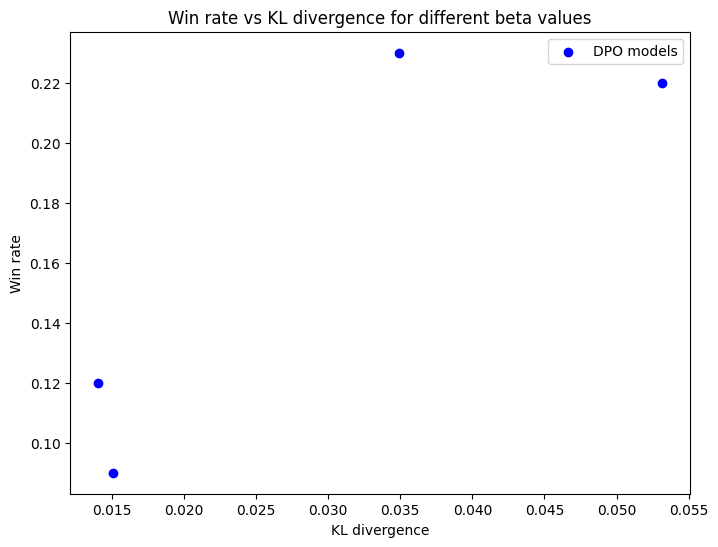

In [12]:
train_dataset, test_dataset = load_and_preprocess_dataset()
model, tokenizer = initialize_models_and_tokenizer()

test_dataset = test_dataset.select(range(100))
prompts = test_dataset["prompt"]
responses_sft = generate_responses(model, tokenizer, prompts)

betas = [0.05, 0.1, 1, 5]
win_rates = []
kl_values = []

for beta in betas:
    gc.collect()
    torch.cuda.empty_cache()
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
    trainer = train_dpo_model(model, tokenizer, train_dataset, beta)

    gc.collect()
    torch.cuda.empty_cache()

    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(DEVICE)
    model_dpo = AutoModelForCausalLM.from_pretrained(f"dpo_model_beta_{beta}").to(DEVICE)

    blender = llm_blender.Blender()
    blender.loadranker("llm-blender/PairRM")

    win_rate, kl_divergence = evaluate_model(model, model_dpo, tokenizer, prompts, blender, responses_sft)
    print(win_rate, kl_divergence )
    win_rates.append(win_rate)
    kl_values.append(kl_divergence)

plot_results(kl_values, win_rates, betas)


In [13]:
class CustomDPOTrainer(DPOTrainer):
    def __init__(self, *args, divergence_type="forward_kl", alpha=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.divergence_type = divergence_type
        self.alpha = alpha
        self.beta = 0.1

    def dpo_loss(
        self,
        chosen_logps: torch.FloatTensor,
        rejected_logps: torch.FloatTensor,
        ref_chosen_logps: torch.FloatTensor,
        ref_rejected_logps: torch.FloatTensor,
    ) -> tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:
        """
        Compute the DPO loss for a batch of policy and reference model log probabilities.
    
        Args:
            chosen_logps (`torch.FloatTensor`):
                Log probabilities of the model for the chosen responses. Shape: `(batch_size,)`.
            rejected_logps (`torch.FloatTensor`):
                Log probabilities of the model for the rejected responses. Shape: `(batch_size,)`.
            ref_chosen_logps (`torch.FloatTensor`):
                Log probabilities of the reference model for the chosen responses. Shape: `(batch_size,)`.
            ref_rejected_logps (`torch.FloatTensor`):
                Log probabilities of the reference model for the rejected responses. Shape: `(batch_size,)`.
    
        Returns:
            A tuple of three tensors: `(losses, chosen_rewards, rejected_rewards)`.
            The losses tensor contains the DPO loss for each example in the batch.
            The `chosen_rewards` and `rejected_rewards` tensors contain the rewards for the chosen and rejected
            responses, respectively.
        """
        device = self.accelerator.device
    
        # Get the log ratios for the chosen and rejected responses
        chosen_logratios = chosen_logps.to(device) - (not self.reference_free) * ref_chosen_logps.to(device)
        rejected_logratios = rejected_logps.to(device) - (not self.reference_free) * ref_rejected_logps.to(device)
    
        # if self.f_divergence_type == FDivergenceType.ALPHA_DIVERGENCE.value:
        #     # The alpha-divergence formula: (1 - u^-alpha) / alpha
        #     # The divergence difference between the chosen and rejected sample is:
        #     #     (1 - u[w]^-alpha) / alpha - (1 - u[l]^-alpha) / alpha
        #     #        = (u[l]^-alpha - u[w]^-alpha) / alpha
        #     # where u[w] and u[l] are the policy/reference probability ratios
        #     # for the chosen and rejected samples, respectively.
        #     alpha_coef = FDivergenceConstants.ALPHA_DIVERGENCE_COEF_DEFAULT
        #     if self.f_divergence_params and FDivergenceConstants.ALPHA_DIVERGENCE_COEF_KEY in self.f_divergence_params:
        #         alpha_coef = float(self.f_divergence_params[FDivergenceConstants.ALPHA_DIVERGENCE_COEF_KEY])
        #     logits = (cap_exp(rejected_logratios * -alpha_coef) - cap_exp(chosen_logratios * -alpha_coef)) / alpha_coef
    
        if self.f_divergence_type == "forward_kl":
            # Прямая KL-дивергенция: f(u) = -1/u
            pi_ratio_w = torch.exp(chosen_logratios)
            pi_ratio_l = torch.exp(rejected_logratios)
            logits = self.beta * (-1 / pi_ratio_w + 1 / pi_ratio_l)
    
        elif self.f_divergence_type == "reverse_kl":
            # Обратная KL-дивергенция: f(u) = log(u + 1)
            pi_ratio_w = torch.exp(chosen_logratios)
            pi_ratio_l = torch.exp(rejected_logratios)
            logits = self.beta * (torch.log(pi_ratio_w + 1) - torch.log(pi_ratio_l + 1))
    
        elif self.f_divergence_type == "alpha_div":
            # Альфа-дивергенция: f(u) = (1 - u^-alpha) / alpha
            alpha_coef = self.alpha  # Используем alpha из параметров
            pi_ratio_w = torch.exp(chosen_logratios)
            pi_ratio_l = torch.exp(rejected_logratios)
            logits = self.beta * ((1 - pi_ratio_l ** (-alpha_coef)) / alpha_coef - (1 - pi_ratio_w ** (-alpha_coef)) / alpha_coef)
    
        elif self.f_divergence_type == "js":
            # JS-дивергенция: f(u) = log(2u / (1 + u))
            pi_ratio_w = torch.exp(chosen_logratios)
            pi_ratio_l = torch.exp(rejected_logratios)
            logits = self.beta * (torch.log(2 * pi_ratio_w / (1 + pi_ratio_w)) - torch.log(2 * pi_ratio_l / (1 + pi_ratio_l)))
    
        else:
            # Оригинальная логика для других типов дивергенций
            logratios = chosen_logps - rejected_logps
            if self.reference_free:
                ref_logratios = torch.tensor([0], dtype=logratios.dtype, device=logratios.device)
            else:
                ref_logratios = ref_chosen_logps - ref_rejected_logps
    
            logratios = logratios.to(self.accelerator.device)
            ref_logratios = ref_logratios.to(self.accelerator.device)
            logits = logratios - ref_logratios
    
            # if self.f_divergence_type == FDivergenceType.JS_DIVERGENCE.value:
            #     # The js-divergence formula: log(2 * u / (1 + u))
            #     # The divergence difference between the chosen and rejected sample is:
            #     #     log(2 * u[w] / (1 + u[w])) - log(2 * u[l] / (1 + u[l]))
            #     #       = log(u[w]) - log(u[l]) - (log(1 + u[w]) - log(1 + u[l]))
            #     # where u[w] and u[l] are the policy/reference probability ratios
            #     # for the chosen and rejected samples, respectively.
            #     logits -= F.softplus(chosen_logratios) - F.softplus(rejected_logratios)
    
        # The beta is a temperature parameter for the DPO loss, typically something in the range of 0.1 to 0.5.
        # We ignore the reference model as beta -> 0. The label_smoothing parameter encodes our uncertainty about the
        # labels and calculates a conservative DPO loss.
        if self.loss_type == "sigmoid":
            losses = (
                -F.logsigmoid(self.beta * logits) * (1 - self.label_smoothing)
                - F.logsigmoid(-self.beta * logits) * self.label_smoothing
            )
    
        elif self.loss_type == "robust":
            losses = (
                -F.logsigmoid(self.beta * logits) * (1 - self.label_smoothing)
                + F.logsigmoid(-self.beta * logits) * self.label_smoothing
            ) / (1 - 2 * self.label_smoothing)
    
        elif self.loss_type == "exo_pair":
            # eqn (16) of the EXO paper: https://huggingface.co/papers/2402.00856
            import math
    
            if self.label_smoothing == 0:
                self.label_smoothing = 1e-3
            losses = (self.beta * logits).sigmoid() * (
                F.logsigmoid(self.beta * logits) - math.log(1 - self.label_smoothing)
            ) + (-self.beta * logits).sigmoid() * (F.logsigmoid(-self.beta * logits) - math.log(self.label_smoothing))
    
        elif self.loss_type == "hinge":
            losses = torch.relu(1 - self.beta * logits)
    
        elif self.loss_type == "ipo":
            # eqn (17) of the paper where beta is the regularization parameter for the IPO loss, denoted by tau in the paper.
            losses = (logits - 1 / (2 * self.beta)) ** 2

        elif self.loss_type == "bco_pair":
            chosen_logratios = chosen_logps - ref_chosen_logps
            rejected_logratios = rejected_logps - ref_rejected_logps
            chosen_rewards = self.beta * chosen_logratios
            rejected_rewards = self.beta * rejected_logratios
            rewards = torch.cat((chosen_rewards, rejected_rewards), 0).mean().detach()
            self.running.update(rewards)
            delta = self.running.mean
            losses = -F.logsigmoid((self.beta * chosen_logratios) - delta) - F.logsigmoid(
                -(self.beta * rejected_logratios - delta)
            )
    
        elif self.loss_type == "sppo_hard":
            # In the paper (https://huggingface.co/papers/2405.00675), SPPO employs a soft probability approach,
            # estimated using the PairRM score. The probability calculation is conducted outside of the trainer class.
            # The version described here is the hard probability version, where P in Equation (4.7) of Algorithm 1 is
            # set to 1 for the winner and 0 for the loser.
            a = chosen_logps - ref_chosen_logps
            b = rejected_logps - ref_rejected_logps
            losses = (a - 0.5 / self.beta) ** 2 + (b + 0.5 / self.beta) ** 2
    
        elif self.loss_type == "nca_pair":
            chosen_rewards = (chosen_logps - ref_chosen_logps) * self.beta
            rejected_rewards = (rejected_logps - ref_rejected_logps) * self.beta
            losses = (
                -F.logsigmoid(chosen_rewards)
                - 0.5 * F.logsigmoid(-chosen_rewards)
                - 0.5 * F.logsigmoid(-rejected_rewards)
            )
    
        elif self.loss_type == "aot_pair":
            chosen_logratios = chosen_logps - ref_chosen_logps
            rejected_logratios = rejected_logps - ref_rejected_logps
            chosen_logratios_sorted, _ = torch.sort(chosen_logratios, dim=0)
            rejected_logratios_sorted, _ = torch.sort(rejected_logratios, dim=0)
            delta = chosen_logratios_sorted - rejected_logratios_sorted
            losses = (
                -F.logsigmoid(self.beta * delta) * (1 - self.label_smoothing)
                - F.logsigmoid(-self.beta * delta) * self.label_smoothing
            )
    
        elif self.loss_type == "aot":
            logratios = chosen_logps - rejected_logps
            ref_logratios = ref_chosen_logps - ref_rejected_logps
            logratios_sorted, _ = torch.sort(logratios, dim=0)
            ref_logratios_sorted, _ = torch.sort(ref_logratios, dim=0)
            delta = logratios_sorted - ref_logratios_sorted
            losses = (
                -F.logsigmoid(self.beta * delta) * (1 - self.label_smoothing)
                - F.logsigmoid(-self.beta * delta) * self.label_smoothing
            )
    
        elif self.loss_type == "apo_zero":
            # Eqn (7) of the APO paper (https://huggingface.co/papers/2408.06266)
            # Use this loss when you believe the chosen outputs are better than your model's default output
            losses_chosen = 1 - F.sigmoid(self.beta * chosen_logratios)  # Increase chosen likelihood
            losses_rejected = F.sigmoid(self.beta * rejected_logratios)  # Decrease rejected likelihood
            losses = losses_chosen + losses_rejected
    
        elif self.loss_type == "apo_down":
            # Eqn (8) of the APO paper (https://huggingface.co/papers/2408.06266)
            # Use this loss when you believe the chosen outputs are worse than your model's default output.
            # Decrease chosen likelihood and decrease rejected likelihood more
            losses_chosen = F.sigmoid(self.beta * chosen_logratios)
            losses_rejected = 1 - F.sigmoid(self.beta * (chosen_logratios - rejected_logratios))
            losses = losses_chosen + losses_rejected
    
        elif self.loss_type == "discopop":
            # Eqn (5) of the DiscoPOP paper (https://huggingface.co/papers/2406.08414)
            # This loss was discovered with LLM discovery
            logratios = chosen_logps - rejected_logps
            ref_logratios = ref_chosen_logps - ref_rejected_logps
            logits = logratios - ref_logratios
            logits = logits * self.beta
            # Modulate the mixing coefficient based on the log ratio magnitudes
            log_ratio_modulation = torch.sigmoid(logits / self.args.discopop_tau)
            logistic_component = -F.logsigmoid(logits)
            exp_component = torch.exp(-logits)
            # Blend between logistic and exponential component based on log ratio modulation
            losses = logistic_component * (1 - log_ratio_modulation) + exp_component * log_ratio_modulation
    
        else:
            raise ValueError(
                f"Unknown loss type: {self.loss_type}. Should be one of ['sigmoid', 'hinge', 'ipo', 'exo_pair', "
                "'nca_pair', 'robust', 'bco_pair', 'sppo_hard', 'aot', 'aot_pair', 'discopop', 'apo_zero', 'apo_down']"
            )
    
        chosen_rewards = self.beta * (chosen_logps.to(device) - ref_chosen_logps.to(device)).detach()
        rejected_rewards = self.beta * (rejected_logps.to(device) - ref_rejected_logps.to(device)).detach()
    
        return losses, chosen_rewards, rejected_rewards

In [14]:
def train_custom_dpo_model(model, tokenizer, train_dataset, divergence_type, alpha=None, output_dir=None):
    dpo_config = DPOConfig(
        beta=0.1,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=16,
        learning_rate=5e-5,
        max_steps=max_steps,
        bf16=True,
        logging_steps=10,
        output_dir=output_dir,
        report_to="none"
    )
    trainer = CustomDPOTrainer(
        model=model,
        args=dpo_config,
        train_dataset=train_dataset,
        tokenizer=tokenizer,
        divergence_type=divergence_type,
        alpha=alpha
    )
    trainer.train()
    trainer.save_model(output_dir)
    return trainer

In [15]:
def plot_kl_win_tradeoff(kl_win_data):
    plt.figure(figsize=(8, 5))
    for name, (kl, win_rate) in kl_win_data.items():
        plt.scatter(kl, win_rate, label=name, s=100)
    plt.xlabel("KL Divergence")
    plt.ylabel("Win Rate")
    plt.title("Tradeoff между KL и Win Rate")
    plt.legend()
    plt.grid()
    plt.show()

<ipython-input-13-02063f9b6f35>:3: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `CustomDPOTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
10,0.697700
20,0.664700
30,0.707600
40,0.655700
50,0.707100
60,0.656200
70,0.642500
80,0.698100
90,0.715200
100,0.627200


/usr/local/lib/python3.10/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type load_checkpoint detected when decoding RankerConfig.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type device detected when decoding RankerConfig.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Successfully loaded ranker from  /root/.cache/huggingface/hub/llm-blender/PairRM


Ranking candidates: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


0.23 0.03493251586332917


<ipython-input-13-02063f9b6f35>:3: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `CustomDPOTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
10,0.697700
20,0.664700
30,0.707600
40,0.655700
50,0.707100
60,0.656200
70,0.642500
80,0.698100
90,0.715200
100,0.627200


/usr/local/lib/python3.10/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type load_checkpoint detected when decoding RankerConfig.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type device detected when decoding RankerConfig.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Successfully loaded ranker from  /root/.cache/huggingface/hub/llm-blender/PairRM


Ranking candidates: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


0.23 0.034932573549449446


<ipython-input-13-02063f9b6f35>:3: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `CustomDPOTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
10,0.697700
20,0.664700
30,0.707600
40,0.655700
50,0.707100
60,0.656200
70,0.642500
80,0.698100
90,0.715200
100,0.627200


/usr/local/lib/python3.10/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type load_checkpoint detected when decoding RankerConfig.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/dataclasses_json/core.py:201: RuntimeWarning: 'NoneType' object value of non-optional type device detected when decoding RankerConfig.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Successfully loaded ranker from  /root/.cache/huggingface/hub/llm-blender/PairRM


Ranking candidates: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]


0.23 0.034932555146515366


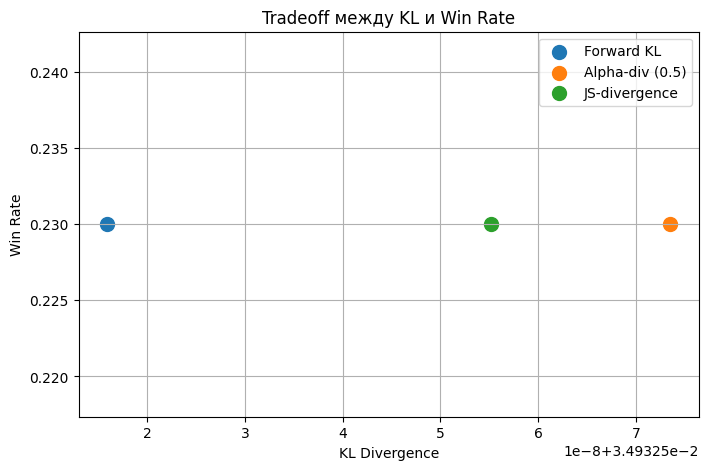

In [16]:
train_dataset, test_dataset = load_and_preprocess_dataset()
model, tokenizer = initialize_models_and_tokenizer()

test_dataset = test_dataset.select(range(100))
prompts = test_dataset["prompt"]
responses_sft = generate_responses(model, tokenizer, prompts)

divergence_types = [
    ("Forward KL", "forward_kl", None, "dpo_forward_kl"),
    ("Alpha-div (0.5)", "alpha_div", 0.5, "dpo_alpha_0.5"),
    ("JS-divergence", "js", None, "dpo_js")
]

kl_win_data = {}

gc.collect()
torch.cuda.empty_cache()

for name, divergence_type, alpha, output_dir in divergence_types:
    gc.collect()
    torch.cuda.empty_cache()

    trainer = train_custom_dpo_model(model, tokenizer, train_dataset, divergence_type, alpha, output_dir)
    
    gc.collect()
    torch.cuda.empty_cache()
    
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(DEVICE)
    model_dpo = AutoModelForCausalLM.from_pretrained(output_dir).to(DEVICE)
    
    blender = llm_blender.Blender()
    blender.loadranker("llm-blender/PairRM")

    win_rate, kl = evaluate_model(model, model_dpo, tokenizer, prompts, blender, responses_sft)
    print(win_rate, kl)
    kl_win_data[name] = (kl, win_rate)

plot_kl_win_tradeoff(kl_win_data)